# Digital Media Business Insights

### Ryan Borchardt
Objective: Answer business questions for the Chinook business in SQL.


Chinook is a fictional, digital music store (similar to iTunes, only much smaller). https://github.com/lerocha/chinook-database <br>

This was originally part of a project I completed in the 'Data Scientist' course on DataQuest. I have since expanded this analysis to extract additional insights from this database.

The chinook database (chinook.db) contains 11 tables, which is displayed in the schema diagram below:<br>

![title](images/chinook_schema.JPG)

## Initial setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Create context manager to handle connection to SQLite database and return dataframe from query
def run_query(q):
    with sqlite3.connect('data/chinook.db') as conn:
        return pd.read_sql_query(q,conn)

### 1. What percent of Chinook's customer base have spent over \$100 total? <br> What percent of Chinook's total sales do these customers account for?

We will categorize those who have spent over \$100 as "big spenders".<br> We will also categorize those who spend less than \$20 as "small spenders" and those in between as "regular spenders".

In [2]:
q1 = '''
WITH intermed_table AS 
    (
    SELECT
        c.country,
        c.first_name || " " || c.last_name customer_name,
        COUNT(i.invoice_id) number_purchases,
        SUM(i.total) total_spent
    FROM customer c
    INNER JOIN invoice i ON i.customer_id=c.customer_id
    GROUP BY i.customer_id 
    ),
    
    intermed_table_2 AS
    (
    SELECT 
        customer_name,
        number_purchases,
        total_spent,
        CASE
            WHEN total_spent < 30 THEN "Small spender"
            WHEN total_spent > 20 AND total_spent < 100 THEN "regular spender"
            ELSE "big_spender"
            END
            AS customer_type
        
    FROM intermed_table
    )


SELECT 
    customer_type, 
    COUNT(customer_name) number_of_customers,
    (CAST(COUNT(customer_name) AS float) / (SELECT COUNT(*) FROM customer))*100 customer_composition,
    SUM(total_spent) total_spent,
    SUM(total_spent) / (SELECT SUM(i.total) FROM invoice i) percent_of_sales
FROM intermed_table_2
GROUP BY customer_type

'''

run_query(q1)

,customer_type,number_of_customers,customer_composition,total_spent,percent_of_sales
0,Small spender,1,1.694915,29.70,0.006306
1,big_spender,7,11.864407,818.73,0.173849
2,regular spender,51,86.440678,3861.00,0.819844


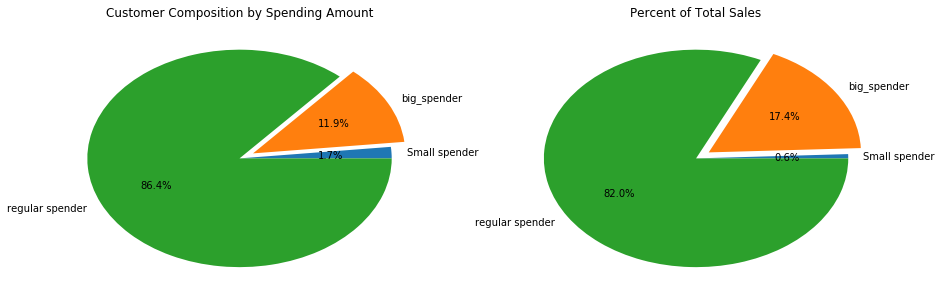

In [3]:
customer_type_df = run_query(q1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.pie(x=customer_type_df['customer_composition'], labels=customer_type_df['customer_type'], autopct='%1.1f%%', explode=(0,0.1,0))
ax1.set_title("Customer Composition by Spending Amount")

ax2.pie(x=customer_type_df['percent_of_sales'], labels=customer_type_df['customer_type'], autopct='%1.1f%%', explode=(0,0.1,0))
ax2.set_title("Percent of Total Sales")

plt.show()

<b>Insights/Observations </b>:<br>
11.9% of Chinook's customer base are "big spenders" (ie have spent over \$100). They account for 17.4% of Chinook's total sales. <br>
Surprisingly, only 1.7% of Chinook's customers have spent less than \$20 and they contribute a very small amount (0.6%) to Chinook's total sales. <br>
The vast majority (86.4%) of Chinook's customers are "regular" spenders (ie have spent between \$20 and \$100) and they account for 82.0% of Chinook's total sales.

<b>Recommendation</b>:<br> Perhaps Chinook should introduce a rewards program to further motivate the "big spenders" and "regular spenders" to continue to make more purchases.

### 2.  What % of Chinook's customer base returned for additional purchases after their initial purchase? <br> What percent of Chinook's customers can be categorized as "loyalty customers" (have returned for a total of 10 or more separate purchases)?

In [4]:
q2 = '''
WITH intermed_table AS 
    (
    SELECT
        customer_id,
        COUNT(i.invoice_id) number_purchases
    FROM invoice i
    GROUP BY customer_id
    ),
    
    intermed_table_2 AS
    (

    SELECT
        customer_id,
        CASE
        WHEN number_purchases = 1 THEN "Did not return"
        WHEN number_purchases > 10 THEN "Loyal customer"
        ELSE "regular customer"
        END
        AS customer_type
    FROM intermed_table
    )


SELECT
    customer_type,
    COUNT(customer_id) number_of_customers,
    (CAST(COUNT(customer_id) as float) / (SELECT COUNT(customer_id) FROM customer))*100 percent
FROM intermed_table_2
GROUP BY customer_type
'''

run_query(q2)

,customer_type,number_of_customers,percent
0,Loyal customer,26,44.067797
1,regular customer,33,55.932203


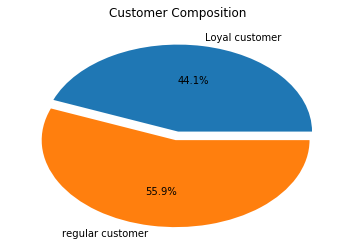

In [5]:
loyalty_customer_df = run_query(q2)

plt.pie(x=loyalty_customer_df['percent'], labels=loyalty_customer_df['customer_type'], autopct='%1.1f%%', explode=(0,0.1))
plt.title("Customer Composition")
plt.show()

<b>Insights/Observations </b>:<br>
Chinook is doing a very effective job at retaining their customers.<br> Almost half (44%) of their customer base have returned for more than 10 total purchases.<br>
Amazingly, 100% of their 59 customers have returned for additional purchases after their initial purchase.<br> 

<b>Recommendation</b>:<br> Whatever Chinook is doing to keep their customers is working really well. They should focus their efforts on aquiring new customers because they are clearly doing a very good job of retaining the customers they do get. Perhaps they should purchase ads to reach a wider audience.

### 3. What genres of music should Chinook focus on expanding for USA customers?

Note that I am going to create an index on the country column for the customer table. I search for specific rows in the country column both in this section as well as in section \#8. Note that this database is pretty small so I don't really need the speed benefits that come w/ creating an index. However, I am going to do it anyway for the practice.

(I created the index in DB Browser for SQLite): <br>
![title](images/customer_country_index.JPG)<br>


In [6]:
q1 = '''
WITH intermed_table_1 AS 
    (
    SELECT TOTAL(il.quantity) 
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id=il.invoice_id
    INNER JOIN customer c ON c.customer_id=i.customer_id
    WHERE c.country="USA"
    ),
    
    intermed_table_2 AS
    (
    SELECT 
        g.name genre_type, 
        SUM(il.quantity) num_tracks_sold_USA,
        (SUM(il.quantity) / (SELECT * FROM intermed_table_1))*100 percent_sold
    FROM invoice_line il
    INNER JOIN track t ON t.track_id=il.track_id
    INNER JOIN genre g ON g.genre_id=t.genre_id
    INNER JOIN invoice i ON i.invoice_id=il.invoice_id
    INNER JOIN customer c ON c.customer_id=i.customer_id
    WHERE c.country="USA"
    GROUP BY 1
    ORDER BY 2 DESC
    ),
    
    intermed_table_3 AS
    (
    SELECT
        g.name genre_type,
        COUNT(t.name) number_of_tracks_available_in_store
    FROM genre g
    INNER JOIN track t ON t.genre_id=g.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    )

SELECT 
    it2.genre_type, 
    it2.num_tracks_sold_USA,
    it3.number_of_tracks_available_in_store,
    (it2.num_tracks_sold_USA/CAST(it3.number_of_tracks_available_in_store AS float)) ratio_sold_to_available
FROM intermed_table_2 it2
INNER JOIN intermed_table_3 it3 ON it3.genre_type=it2.genre_type
ORDER BY 4 DESC
LIMIT 10
'''

run_query(q1)

,genre_type,num_tracks_sold_USA,number_of_tracks_available_in_store,ratio_sold_to_available
0,Alternative,35,40,0.875000
1,R&B/Soul,53,61,0.868852
2,Hip Hop/Rap,20,35,0.571429
3,Easy Listening,13,24,0.541667
4,Pop,22,48,0.458333
5,Blues,36,81,0.444444
6,Rock,561,1297,0.432537
7,Alternative & Punk,130,332,0.391566
8,Metal,124,374,0.331551
9,Electronica/Dance,5,30,0.166667


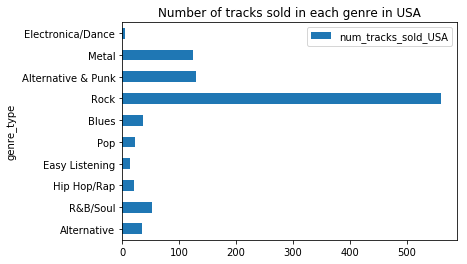

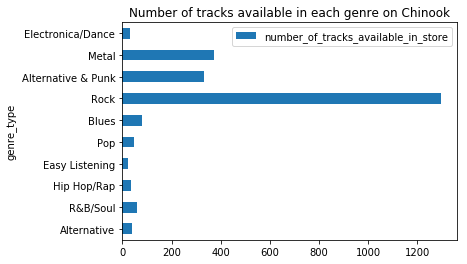

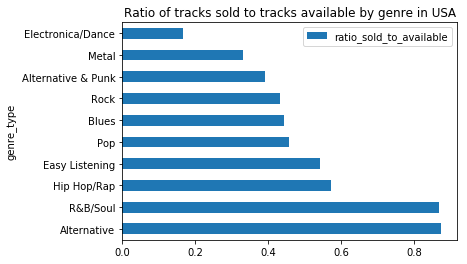

In [7]:
genre_sold_df = run_query(q1)
genre_sold_df.plot.barh(x='genre_type', y='num_tracks_sold_USA', title='Number of tracks sold in each genre in USA')
genre_sold_df.plot.barh(x='genre_type', y='number_of_tracks_available_in_store', title='Number of tracks available in each genre on Chinook')
genre_sold_df.plot.barh(x='genre_type', y='ratio_sold_to_available', title='Ratio of tracks sold to tracks available by genre in USA')

plt.show()

<b>Insights/Observations </b>:<br>
Although rock is by far the best-selling genre in the USA on Chinook (561 tracks sold), this is also the genre with by far the most tracks available in the store (1,297 tracks in Rock genre available on Chinook store). Perhaps the rock genre is the best-selling genre partly due to the fact that such a high amount of the tracks available on Chinook are in the rock genre. <br><br>
It may be best for Chinook to purchase more tracks in the Alternative and R&B genres to better fit the USA customers' needs. This is b/c these two genres are proportionally selling the highest amount of tracks when compared to the amount of tracks available on the store (For the Alternative genre, only 35 tracks have been sold in the USA BUT only 40 tracks in the alternative genre are available on Chinook). These genres sell best if we take into account the amount of tracks available on the store.

<b>Recommendation</b>: Chinook should focus on purchasing more tracks in the Alternative and R&B genres to better meet their USA customers' needs. If they are looking to continue to expand and grow their customer base in the USA rock community, they can focus on purchasing more tracks in the rock genre.

### 4. How many of the purchases are purchases of an album? 

Note that in this method, only album purchases for one single album count as an album purchase. <br><br>
Situations that DON'T count as a single album purchase:
    1. purchase of a variety of tracks from different albums
    2. purchase of only a fraction of tracks from an album
    3. purchase of multiple whole albums 
    

I created a view for the a table where invoice, invoice_line and track are joined into a table and condensed by invoice_id. The result is a table where only one album is listed per invoice_id (the album corresponding to the track that corresponds to the last invoice_line in each invoice. <br>
(I created the view in DB Browser for SQLite):<br>
![title](images/invoice_condensed_view_1.JPG)<br>

I created a second view where I added a new column for categorizing each invoice_id as being an album purchase or not. I did this using the set operator 'EXCEPT' where for each invoice_id, I compared all of the tracks that are in the album (the album that is listed for the given invoice_id in the invoice_condensed view) to all of the tracks that were purchased in that invoice and vice-versa. If no tracks were leftover in both of these set operations (ie a NULL result is returned), then I assign a "YES" to the an_album_purchase column. Otherwise (ie when there are extra tracks leftover that aren't tracks in the album in the invoice_condensed view or vice-versa), I assign a "NO" to the an_album_purchase column:

![image.png](images/an_album_purchase_table_view.JPG)

In [8]:
q4_a = '''
SELECT * 
FROM an_album_purchase_table
LIMIT 10
'''
q4_b = '''
SELECT 
    COUNT(*) num_album_purchase
FROM an_album_purchase_table
GROUP BY an_album_purchase
'''
album_purchase_df = run_query(q4_b)
run_query(q4_a)

,invoice_id,an_album_purchase
0,1,YES
1,2,NO
2,3,NO
3,4,NO
4,5,YES
5,6,NO
6,7,NO
7,8,NO
8,9,NO
9,10,NO


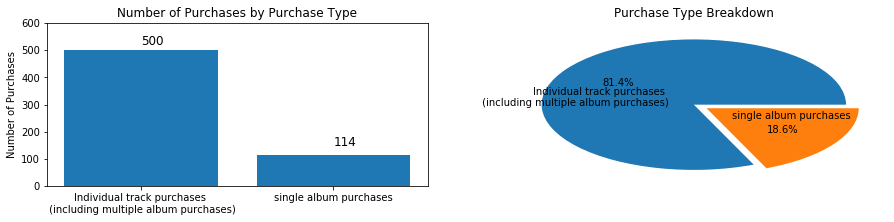

In [9]:
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
labeling = ["Individual track purchases \n (including multiple album purchases)", "single album purchases"]
ax1.bar(x=labeling, height =album_purchase_df['num_album_purchase'])
ax1.set_title("Number of Purchases by Purchase Type")
ax1.set_ylabel('Number of Purchases')
ax1.set_ylim(0,600)
ax1.text(x=0.000001,y=520,s=album_purchase_df.loc[0,'num_album_purchase'], fontsize=12)
ax1.text(x=1,y=150,s=album_purchase_df.loc[1,'num_album_purchase'], fontsize=12)

ax2.pie(x=album_purchase_df['num_album_purchase'], labels=labeling, autopct='%1.1f%%', explode=(0,0.1), labeldistance=.2)
ax2.set_title("Purchase Type Breakdown")


plt.show()

<b>Insights/Observations </b>:<br>
114 (18.6%) of the purchases on Chinook are purchases of a whole album.

### 5. What does the employee hierarchical structure look like? 

In [10]:
q5 = '''
SELECT
    e1.first_name || " " || e1.last_name employee_name,
    e1.title,
    e2.first_name || " " || e2.last_name supervisor_name
FROM employee e1
LEFT JOIN employee e2 ON e2.employee_id=e1.reports_to
'''

df = run_query(q5)

df.loc[df['supervisor_name'].isnull(),"layer"]=1
df.loc[df['supervisor_name']=='Andrew Adams',"layer"]=2
df.loc[df['supervisor_name']=='Nancy Edwards',"layer"]=3
df.loc[df['supervisor_name']=='Michael Mitchell',"layer"]=3

df['layer']=df['layer'].astype(int)

#Need to figure out how I can use spaces rather than underscores.

for index, row in df.iterrows():
    df.loc[index,'employee_name'] = "______"*(row['layer']-1) + row['employee_name']
    
#print(df)

In [11]:
#left-justifying columns in Pandas is incredibly inconvenient.
def column_styling (col):
    if col.name == "employee_name":
        align = "left"
    else:
        align = "right"

    return ["text-align: %s" % align ] * len(col)

df.style.apply(column_styling)

,employee_name,title,supervisor_name,layer
0,Andrew Adams,General Manager,None,1
1,______Nancy Edwards,Sales Manager,Andrew Adams,2
2,____________Jane Peacock,Sales Support Agent,Nancy Edwards,3
3,____________Margaret Park,Sales Support Agent,Nancy Edwards,3
4,____________Steve Johnson,Sales Support Agent,Nancy Edwards,3
5,______Michael Mitchell,IT Manager,Andrew Adams,2
6,____________Robert King,IT Staff,Michael Mitchell,3
7,____________Laura Callahan,IT Staff,Michael Mitchell,3


<b>Insights/Observations </b>:<br> The Chinook team is divided into two divisions: the Sales division and the IT division. Nancy Edwards is the manager of the Sales division and supervizes the three Sales Support Agents. Michael Mitchell is the manager of the IT division and supervizes the two IT staff. Andrew Adams, as the General Manager, is the supervisor to the two managers. 

### 6. How are Chinook's sales support agents performing? 

In [12]:
q2 = '''
SELECT 
    e.first_name || " " || e.last_name sales_agent,
    e.hire_date,
    SUM(i.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id=e.employee_id
INNER JOIN invoice i ON i.customer_id=c.customer_id
GROUP BY e.employee_id
ORDER BY 2 DESC
'''

run_query(q2)

,sales_agent,hire_date,total_sales
0,Steve Johnson,2017-10-17 00:00:00,1393.92
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Jane Peacock,2017-04-01 00:00:00,1731.51


Jane Peacock appears to have the highest sales while Steve Johnson appears to have the least amount of sales. However, Jane Peacock has worked at Chinook longer than Steve. Need to take length of employment into account. Will add column for average sales per day:<br> (total_sales / number_of_days_employed)

In [13]:
q3 = '''
SELECT MAX(invoice_date)
FROM invoice
'''

run_query(q3)

,MAX(invoice_date)
0,2020-12-30 00:00:00


Let us assume that this is the current date for the dataset (the most recent sale occured on Dec 30, 2020 -> this must be a dataset from the future.)

In [14]:
q5 = '''
SELECT typeof(hire_date)
FROM employee
'''

run_query(q5)

,typeof(hire_date)
0,text
1,text
2,text
3,text
4,text
5,text
6,text
7,text


Note that the hire_date column is a text value. Will use regex expressions to convert this string into number of days. Will convert this hire_date column from text to number of days since year 0. This will work b/c we only need to find the difference between the most recent sale (Dec 30, 2020) and the hire_date column. 

In [15]:
q6 = '''
WITH  
    intermed_table_1 AS
    (
    SELECT CAST(substr(hire_date,1,4) as int)*365+ CAST(substr(hire_date,6,2) as int)*30 + CAST(substr(hire_date,9,2) as int)*1 date_num,
    employee_id
    FROM employee
    ),
    
    intermed_table_2 AS
    (
    SELECT MAX(invoice_date) latest_date
    FROM invoice
    ),
    
    intermed_table_3 AS
    (
    SELECT CAST(substr(latest_date,1,4) as int)*365+ CAST(substr(latest_date,6,2) as int)*30 + CAST(substr(latest_date,9,2) as int)*1
    FROM intermed_table_2
    ),
    
    intermed_table_4 AS
    (
    SELECT 
        (SELECT CAST(substr(latest_date,1,4) as int)*365+ CAST(substr(latest_date,6,2) as int)*30 + CAST(substr(latest_date,9,2) as int)*1 - date_num
        FROM intermed_table_2) days_employed,
        employee_id
    FROM intermed_table_1
    )
    
     
SELECT 
    e.first_name || " " || e.last_name sales_agent,
    e.hire_date,
    it4.days_employed,
    SUM(i.total) total_sales,
    SUM(i.total)/(it4.days_employed*232/365) sales_per_workday_dollars
FROM employee e
INNER JOIN customer c ON c.support_rep_id=e.employee_id
INNER JOIN invoice i ON i.customer_id=c.customer_id
INNER JOIN intermed_table_4 it4 ON it4.employee_id = e.employee_id
GROUP BY e.employee_id
ORDER BY 5 DESC
'''

#In my calculation for sales_per_workday_dollars, I assume that the employees worked 232 days out of the year (5*52-28 vacation/holiday/sick days)

run_query(q6)

,sales_agent,hire_date,days_employed,total_sales,sales_per_workday_dollars
0,Jane Peacock,2017-04-01 00:00:00,1364,1731.51,1.999434
1,Steve Johnson,2017-10-17 00:00:00,1168,1393.92,1.878598
2,Margaret Park,2017-05-03 00:00:00,1332,1584.00,1.872340


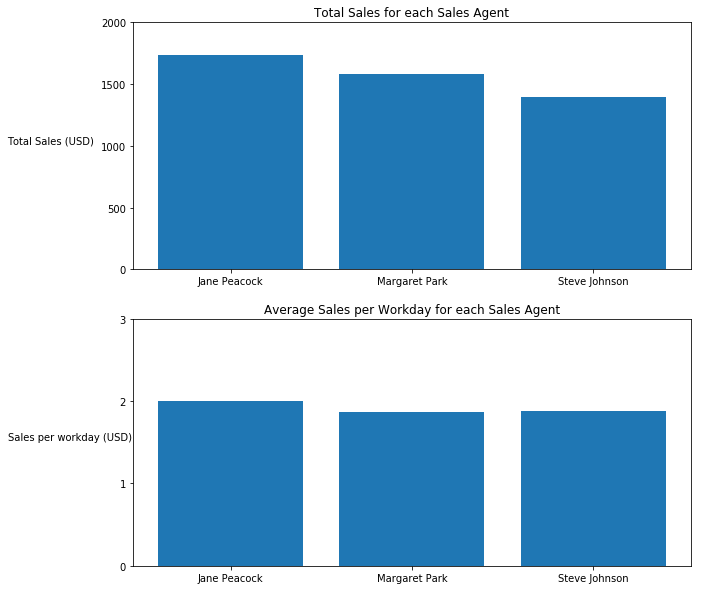

In [16]:
sales_agent_perform_df = run_query(q6)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.bar(x=sales_agent_perform_df['sales_agent'], height=sales_agent_perform_df['total_sales'])
ax1.set_title("Total Sales for each Sales Agent")
ax1.set_ylabel("Total Sales (USD)", rotation=0, labelpad=50)
ax1.set_yticks(ticks=[0,500,1000,1500,2000])
ax2.bar(x=sales_agent_perform_df['sales_agent'], height=sales_agent_perform_df['sales_per_workday_dollars'])
ax2.set_title("Average Sales per Workday for each Sales Agent")
ax2.set_ylabel("Sales per workday (USD)", rotation=0, labelpad=50)
ax2.set_yticks(ticks=[0,1,2,3])
plt.show()

<b>Insights/Observations </b>:<br>
1. It turns out that all three sales agents peform about the same (their sales per workday are about the same).<br>
2. Even though Steve Johnson has the least amount of total sales, he has been working there the shortest amount of time. If you take that into account, he is performing the second best (he has the second most sales per workday).
3. These sales agents may not be performing well: they all average $2 or less in sales per workday. Hopefully these sales agents work very limited hours or do this on a volunteer basis.

### 7. What email service providers do our customers use? 
(pattern matching example)

In [17]:
q7 = '''
SELECT
    (
    SELECT COUNT(*)
    FROM customer
    WHERE email LIKE '%gmail%'
    ) gmail,
    (
    SELECT COUNT(*)
    FROM customer
    WHERE email LIKE '%yahoo%'
    ) yahoo,
    (
    SELECT COUNT(*)
    FROM customer
    WHERE email LIKE '%apple%'
    ) apple,
    (
    SELECT COUNT(*)
    FROM customer
    WHERE email LIKE '%hotmail%'
    ) hotmail,
    (
    SELECT COUNT(*)
    FROM customer
    WHERE email LIKE '%aol%'
    ) aol

    
FROM customer
LIMIT 1
'''

run_query(q7)

email_df = run_query(q7)
#Calculate # of customers whose email is not from one of the main email providers:
email_df['Other'] = 59 -email_df.loc[0].sum()

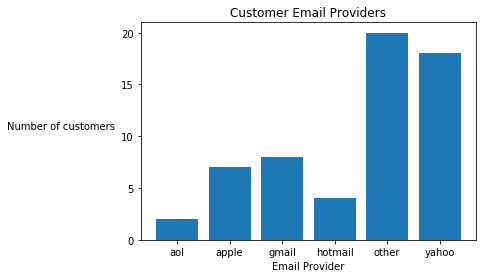

In [18]:
labels = ['gmail', 'yahoo', 'apple', 'hotmail', 'aol','other']
plt.bar(x=labels, height=email_df.loc[0])
plt.title('Customer Email Providers')
plt.xlabel('Email Provider')
plt.ylabel('Number of customers',rotation=0, labelpad=60)
plt.yticks((0,5,10,15,20))
plt.show()

The most common email provider for Chinook's customers is at a yahoo domain (18 customers). Gmail and apple are also relatively popular (8 and 7 customers, respectively). There are 20 customers whose email is not one of the main email providers (gmail,yahoo,apple,hotmail,aol). 

### 8. What does the sales data look like for customers from each country?


In [19]:
q9 = '''

WITH intermed_table_1 AS 
    (
    SELECT
        CASE
            WHEN COUNT(DISTINCT c.customer_id) = 1 THEN "Other"
            WHEN COUNT(DISTINCT c.customer_id) > 1 THEN c.country
            END
            AS country_name,
        COUNT(DISTINCT c.customer_id) total_num_customers,
        SUM(i.total) total_sales,
        SUM(i.total)/COUNT(distinct c.customer_id) avg_value_sales_per_customer,
        SUM(i.total)/COUNT(distinct i.invoice_id) avg_order_value
    FROM customer c
    INNER JOIN invoice i on i.customer_id=c.customer_id
    GROUP BY c.country
    ORDER BY 2 DESC
    ),
    
    intermed_table_2 AS 
    (
    SELECT 
        *,
        CASE
            WHEN country_name = "Other" THEN 0
            ELSE 1
            END
            AS sorting_val
    FROM intermed_table_1
    GROUP BY country_name
    ORDER BY sorting_val DESC
    )
    
    
SELECT 
    country_name,
    total_num_customers,
    total_sales,
    avg_value_sales_per_customer,
    avg_order_value
FROM intermed_table_2
ORDER BY 3 DESC
'''

run_query(q9)

,country_name,total_num_customers,total_sales,avg_value_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,1,75.24,75.240000,7.524000


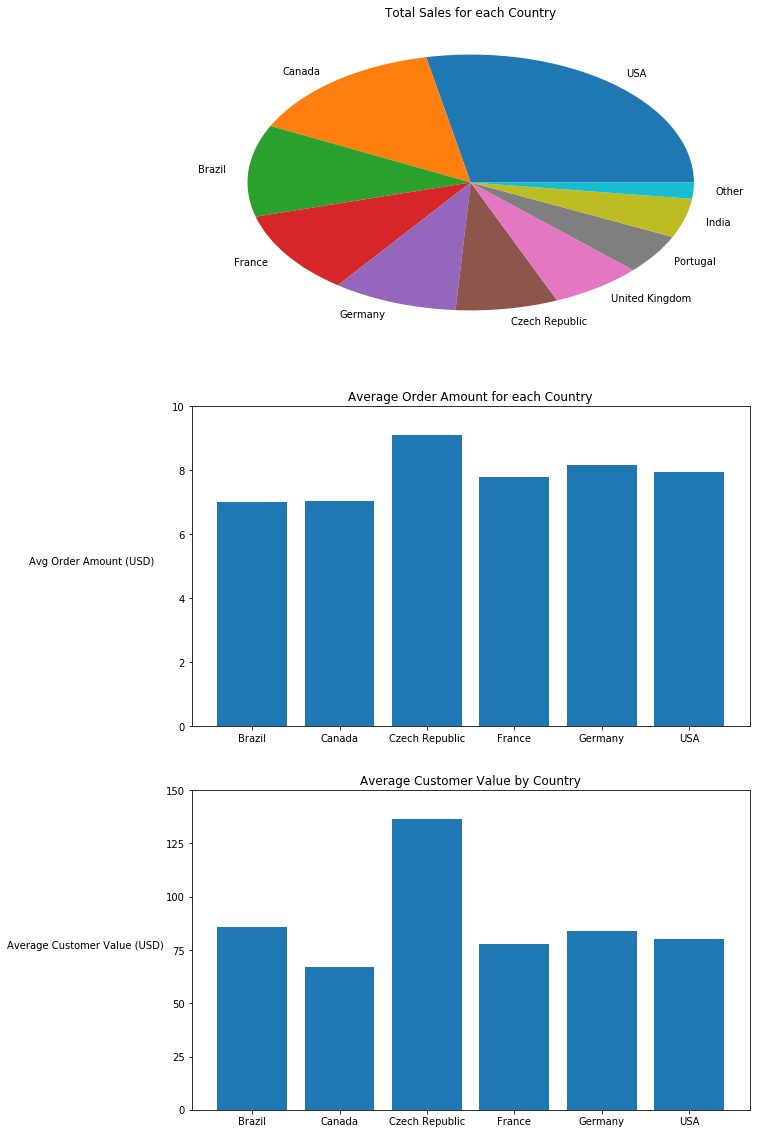

In [20]:
customer_df = run_query(q9)

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.pie(x=customer_df['total_sales'], labels=customer_df['country_name'])
ax1.set_title("Total Sales for each Country")

ax2.bar(x=customer_df.loc[0:5,'country_name'], height=customer_df.loc[0:5,'avg_order_value'])
ax2.set_title("Average Order Amount for each Country")
ax2.set_ylabel("Avg Order Amount (USD)", rotation=0, labelpad=80)
ax2.set_yticks(ticks=[0,2,4,6,8,10])

ax3.bar(x=customer_df.loc[0:5,'country_name'], height=customer_df.loc[0:5,'avg_value_sales_per_customer'])
ax3.set_title("Average Customer Value by Country")
ax3.set_ylabel("Average Customer Value (USD)", rotation=0, labelpad=80)
ax3.set_yticks(ticks=[0,25,50,75,100,125,150])
plt.show()

<b>Insights/Observations</b>: Chinook is getting a lot (roughly half) of its sales from customers in the USA, Canada and Brazil. The two customers from the Czech Republic average higher order amounts and have a higher average customer value than other countries.

### 9. How do tracks of different length sell?  Should Chinook focus on expanding their library of music on tracks of a particular length?

In [21]:
q5 = '''
SELECT
    COUNT(il.track_id) num_tracks_purchased,
    CASE
        WHEN t.milliseconds/1000 <90 THEN 0
        WHEN t.milliseconds/1000 >90 AND t.milliseconds/1000 <180 THEN 1
        WHEN t.milliseconds/1000 >180 AND t.milliseconds/1000 <270 THEN 2
        WHEN t.milliseconds/1000 >270 AND t.milliseconds/1000 <360 THEN 3
        ELSE 4
        END
        AS length_cat
FROM invoice_line il
LEFT JOIN track t on t.track_id=il.track_id
GROUP BY 2

'''


q6 = '''
SELECT
    COUNT(t.track_id) num_tracks_available,
    CASE
        WHEN t.milliseconds/1000 <90 THEN 0
        WHEN t.milliseconds/1000 >90 AND t.milliseconds/1000 <180 THEN 1
        WHEN t.milliseconds/1000 >180 AND t.milliseconds/1000 <270 THEN 2
        WHEN t.milliseconds/1000 >270 AND t.milliseconds/1000 <360 THEN 3
        ELSE 4
        END
        AS length_cat
FROM track t
GROUP BY 2
'''

run_query(q6)

,num_tracks_available,length_cat
0,49,0
1,429,1
2,1505,2
3,855,3
4,665,4


In [22]:
q7 = '''
WITH table_1 AS
    (
    SELECT
        COUNT(il.track_id) num_tracks_purchased,
        CASE
            WHEN t.milliseconds/1000 <90 THEN 0
            WHEN t.milliseconds/1000 >90 AND t.milliseconds/1000 <180 THEN 1
            WHEN t.milliseconds/1000 >180 AND t.milliseconds/1000 <270 THEN 2
            WHEN t.milliseconds/1000 >270 AND t.milliseconds/1000 <360 THEN 3
            ELSE 4
            END
            AS length_cat
    FROM invoice_line il
    LEFT JOIN track t on t.track_id=il.track_id
    GROUP BY 2
    ),
    
    table_2 AS
    (
    SELECT
        COUNT(t.track_id) num_tracks_available,
        CASE
            WHEN t.milliseconds/1000 <90 THEN 0
            WHEN t.milliseconds/1000 >90 AND t.milliseconds/1000 <180 THEN 1
            WHEN t.milliseconds/1000 >180 AND t.milliseconds/1000 <270 THEN 2
            WHEN t.milliseconds/1000 >270 AND t.milliseconds/1000 <360 THEN 3
            ELSE 4
            END
            AS length_cat
    FROM track t
    GROUP BY 2
    )
    
SELECT
    t1.length_cat length_category,
    t1.num_tracks_purchased,
    t2.num_tracks_available,
    CAST(t1.num_tracks_purchased AS float)/t2.num_tracks_available ratio_purchased_to_available
FROM table_1 t1
INNER JOIN table_2 t2 ON t2.length_cat=t1.length_cat
    
    
'''

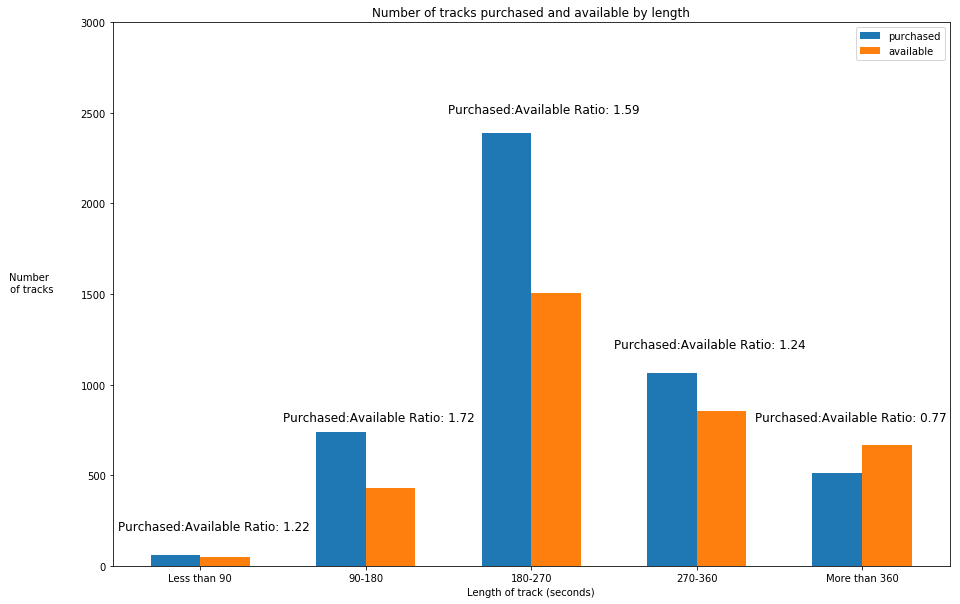

,length_category,num_tracks_purchased,num_tracks_available,ratio_purchased_to_available
0,0,60,49,1.224490
1,1,736,429,1.715618
2,2,2387,1505,1.586047
3,3,1062,855,1.242105
4,4,512,665,0.769925


In [23]:
import seaborn as sns
import numpy as np

length_purchased_df = run_query(q5)
length_available_df = run_query(q6)

labels = ["90", "90-180", "180-270", "270-360", "More than 360"]
x = np.array([2,3,4,5,6])

width=0.3

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)

ax1.bar(x-width/2, width=width, height=length_purchased_df['num_tracks_purchased'], label='purchased')
ax1.bar(x+width/2, width=width, height=length_available_df['num_tracks_available'], label='available')

ax1.set_ylabel('Number \n of tracks', rotation=0,labelpad=50)
ax1.set_title('Number of tracks purchased and available by length')
ax1.set_xticks([2,3,4,5,6])
ax1.set_yticks([0,500,1000,1500,2000,2500,3000])
ax1.set_xticklabels(["Less than 90", "90-180", "180-270", "270-360", "More than 360"])
ax1.set_xlabel('Length of track (seconds)')
ax1.legend()
ax1.text(x=1.5,y=200,s="Purchased:Available Ratio: 1.22", fontsize=12)
ax1.text(x=2.5,y=800,s="Purchased:Available Ratio: 1.72", fontsize=12)
ax1.text(x=3.5,y=2500,s="Purchased:Available Ratio: 1.59", fontsize=12)
ax1.text(x=4.5,y=1200,s="Purchased:Available Ratio: 1.24", fontsize=12)
ax1.text(x=5.35,y=800,s="Purchased:Available Ratio: 0.77", fontsize=12)

plt.show()
run_query(q7)

<b>Insights/Observations</b>:<br> 
Tracks longer than 360 seconds don't get as good of a return as shorter tracks. These longer tracks have a much lower purchased:available ratio than tracks of a shorter length.

<b>Recommendation</b>:<br> 
Perhaps Chinook should focus on expanding their library of tracks that are between 90 and 270 seconds (Chinook seems to get a better return on tracks of this length).<br> 
Their tracks that are longer than 360 seconds seem to get a worse return(they have bought the liscenses for more tracks than they have sold in this category).<br>
Note that more details on the licensing of tracks (not available in this database) is needed for a more thorough analysis of this topic.

### 10. What do Chinook's sales trends look like? Are there any trends?  Are they growing? 

In [24]:
q7 = '''
SELECT
    invoice_id,
    invoice_date,
    SUM(total) total_sales,
    substr(invoice_date,0,5) year,
    substr(invoice_date,7,1) month,
    CAST(substr(invoice_date,0,5) as int) + CAST(substr(invoice_date,7,1) AS float)/12 month_period     
FROM invoice
GROUP BY 6
'''

q8='''
SELECT
    invoice_id,
    invoice_date,
    SUM(total) total_sales,
    substr(invoice_date,0,5) year,
    substr(invoice_date,7,1) month,
    CAST(substr(invoice_date,0,5) as int) + CAST(substr(invoice_date,7,1) AS float)/12 month_period     
FROM invoice
GROUP BY 4
'''

#run_query(q7)

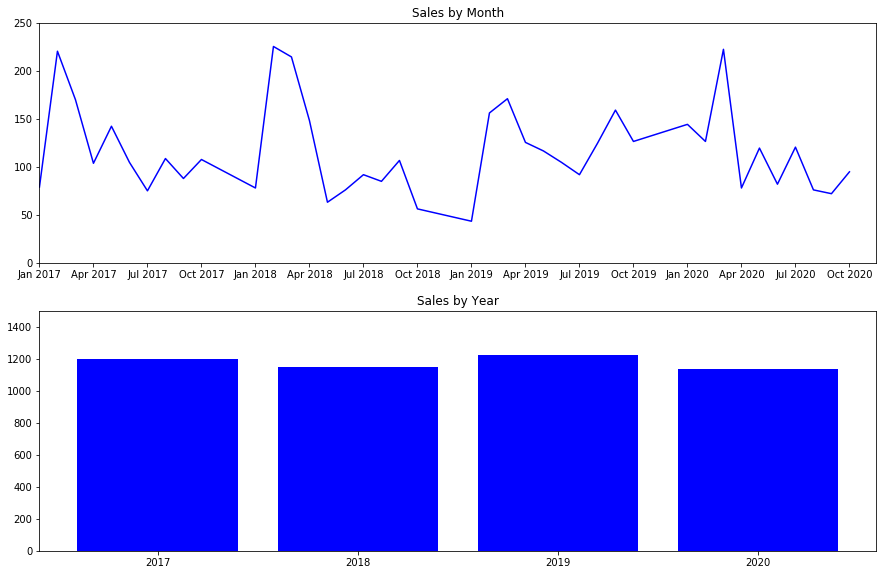

In [25]:
monthly_sales_df = run_query(q7)
yearly_sales_df = run_query(q8)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
#ax3 = fig.add_subplot(3,1,3)

#Don't explicitly set x=monthly_sales_df['month_period'],y= monthly_sales_df['total'] -> line doesn't show in this form
ax1.plot(monthly_sales_df['month_period'], monthly_sales_df['total_sales'], color='blue')
ax1.set_title("Sales by Month")
ax1.set_xlim(left=2017, right=2020.875)
ax1.set_ylim(bottom=0,top=250)
ax1.set_xticks([2017.0,2017.25,2017.50,2017.75,2018,2018.25,2018.50,2018.75,2019,2019.25,2019.50,2019.75,2020,2020.25,2020.50,2020.75])
ax1.set_xticklabels(["Jan 2017", "Apr 2017", "Jul 2017", "Oct 2017", "Jan 2018", "Apr 2018", "Jul 2018", "Oct 2018", "Jan 2019", "Apr 2019", "Jul 2019", "Oct 2019", "Jan 2020", "Apr 2020", "Jul 2020", "Oct 2020"])

ax2.bar(yearly_sales_df['year'], yearly_sales_df['total_sales'], color='blue')
ax2.set_title("Sales by Year")
ax2.set_ylim(bottom=0,top=1500)


plt.show()

<b>Insights/Observations</b>:<br> 
There seems to be a seasonal trend: Sales tend to rapidly increase January through February, followed by a drop/decrease in sales through April, followed by a small fluctuations throughout the remainder of each year. <br><br>
Chinook's total sales per year has remained roughly the same from 2017 through 2020. Their business is not growing.

<b>Recommendation</b>:<br> 
Perhaps offer discounts and deals April through December to try to increase sales during this decreased period.

Need to find way to increase sales from year to year: Invest in customer acquisition - sell ads? - anything to grow customer base. As we saw above, Chinook seems to be doing a great job at keeping/retaining their customers, they just need to get more customers.